In [76]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [77]:
# Load and Prepare Population Data
df = pd.read_csv('raw/vietnam.csv', encoding='utf-8')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.dropna(subset=['Year']).sort_values('Year').reset_index(drop=True)

# Handle percentages and numeric columns
df['Urban Pop %'] = df['Urban Pop %'].astype(str).str.replace('%', '').astype(float)
df['Yearly % Change'] = df['Yearly % Change'].astype(str).str.replace('%', '').astype(float)

# Interpolate missing values if any
df = df.interpolate(method='linear')

print("Data loaded and prepared. Shape:", df.shape)
print(df.head())

Data loaded and prepared. Shape: (71, 13)
   Year  Population  Yearly % Change  Yearly Change  Migrants (net)  \
0  1955    28166446             3.09         869235               0   
1  1956    29035681             3.09         869235               0   
2  1957    29884089             2.92         848408               0   
3  1958    30804081             3.08         919992               0   
4  1959    31750430             3.07         946349               0   

   Median Age  Fertility Rate  Density (P/Km²)  Urban Pop %  Urban Population  \
0        22.0            5.54               91         13.1           3689800   
1        21.6            5.69               94         13.4           3890780   
2        21.3            5.83               96         13.8           4124000   
3        20.9            5.98               99         14.1           4343380   
4        20.6            6.12              102         14.5           4603810   

   Country's Share of World Pop  World Popul

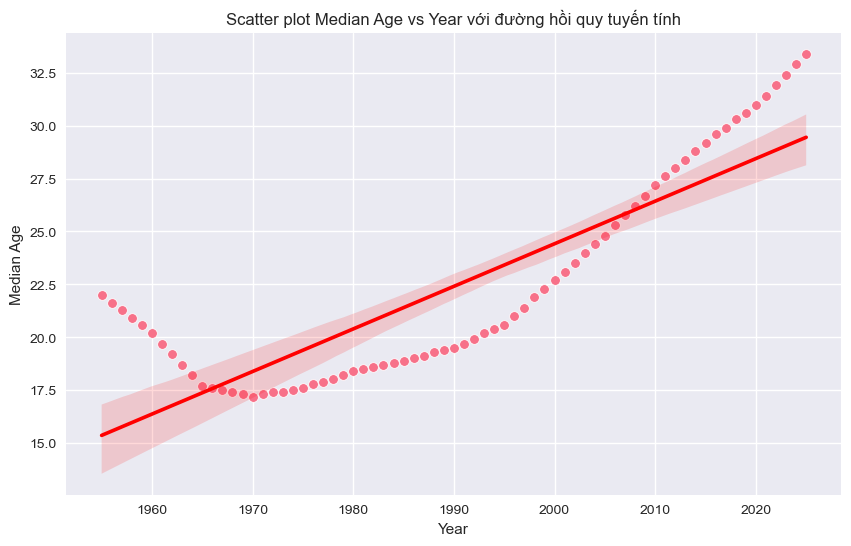

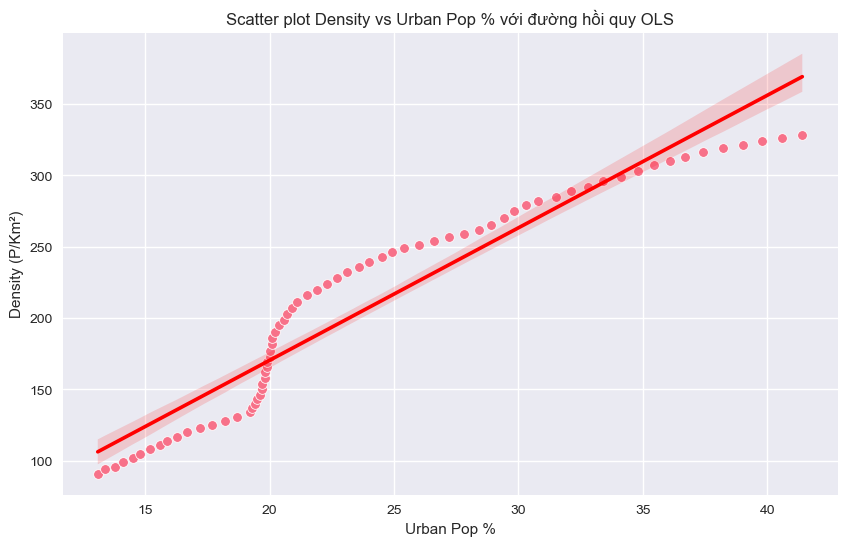

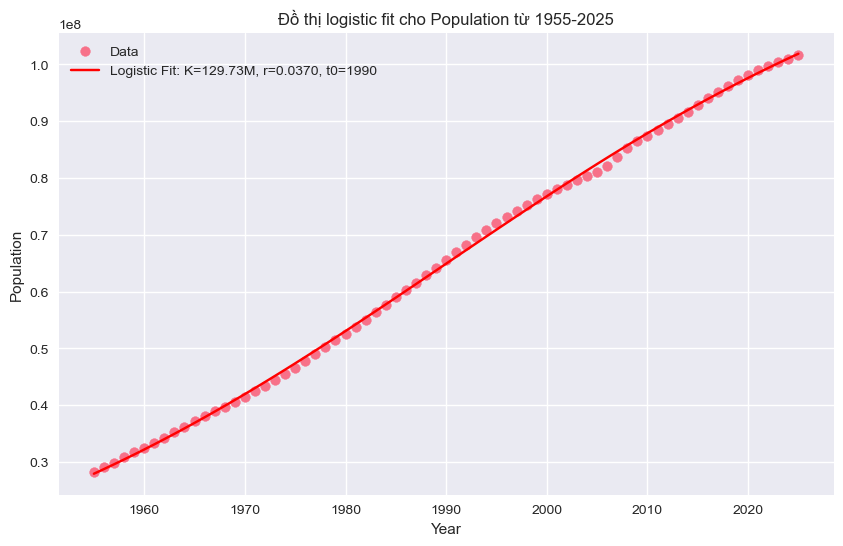

In [78]:
# Generate Visualizations for Key Trends

# Scatter plot Median Age vs Year with OLS regression
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Year', y='Median Age')
sns.regplot(data=df, x='Year', y='Median Age', scatter=False, color='red')
plt.title('Scatter plot Median Age vs Year với đường hồi quy tuyến tính')
plt.xlabel('Year')
plt.ylabel('Median Age')
plt.savefig('populations/median_age_regression.png', dpi=100, bbox_inches='tight')
plt.show()

# Scatter plot Density vs Urban Pop % with OLS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Urban Pop %', y='Density (P/Km²)')
sns.regplot(data=df, x='Urban Pop %', y='Density (P/Km²)', scatter=False, color='red')
plt.title('Scatter plot Density vs Urban Pop % với đường hồi quy OLS')
plt.xlabel('Urban Pop %')
plt.ylabel('Density (P/Km²)')
plt.savefig('populations/density_urban_ols.png', dpi=100, bbox_inches='tight')
plt.show()

# Logistic fit for Population
def logistic_func(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

years = df['Year'].values
population = df['Population'].values
popt, _ = curve_fit(logistic_func, years, population, p0=[130e6, 0.04, 1990])
K, r, t0 = popt

plt.figure(figsize=(10, 6))
plt.scatter(years, population, label='Data')
plt.plot(years, logistic_func(years, *popt), 'r-', label=f'Logistic Fit: K={K/1e6:.2f}M, r={r:.4f}, t0={t0:.0f}')
plt.title('Đồ thị logistic fit cho Population từ 1955-2025')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.savefig('populations/logistic_population_fit.png', dpi=100, bbox_inches='tight')
plt.show()

In [79]:
# Perform Deeper Statistical Analysis

# OLS for Density vs Urban Pop %
X = df[['Urban Pop %']].values
X = np.column_stack([np.ones(len(X)), X])  # Add intercept
y = df['Density (P/Km²)'].values
model = OLS(y, X).fit()
print("OLS Summary for Density vs Urban Pop %:")
print(model.summary())

# Breusch-Pagan test for heteroskedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan test: LM Stat={bp_test[0]:.2f}, p-value={bp_test[1]:.4f}")
if bp_test[1] < 0.05:
    print("Heteroskedasticity detected. Consider GLS.")
else:
    print("No heteroskedasticity.")

# VIF for multicollinearity (example with multiple variables)
# For simplicity, check VIF on a subset
subset = df[['Fertility Rate', 'Median Age', 'Urban Pop %']].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = subset.columns
vif_data["VIF"] = [variance_inflation_factor(subset.values, i) for i in range(len(subset.columns))]
print("VIF for multicollinearity:")
print(vif_data)

OLS Summary for Density vs Urban Pop %:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     753.8
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           7.29e-39
Time:                        08:14:57   Log-Likelihood:                -317.60
No. Observations:                  71   AIC:                             639.2
Df Residuals:                      69   BIC:                             643.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

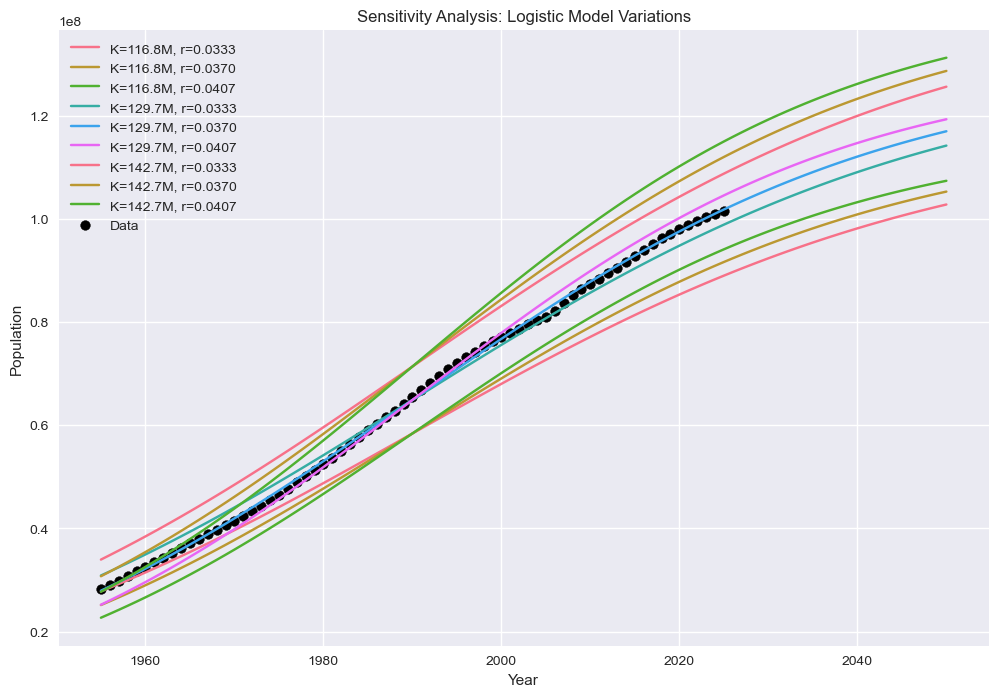

95% CI for Population in 2050: 115.78M - 117.82M


In [80]:
# Conduct Sensitivity Analysis for Forecasts

# Sensitivity to K and r
K_sens = [K * 0.9, K, K * 1.1]
r_sens = [r * 0.9, r, r * 1.1]

plt.figure(figsize=(12, 8))
for k in K_sens:
    for rr in r_sens:
        pred = logistic_func(np.arange(1955, 2051), k, rr, t0)
        plt.plot(np.arange(1955, 2051), pred, label=f'K={k/1e6:.1f}M, r={rr:.4f}')

plt.scatter(years, population, color='black', label='Data')
plt.title('Sensitivity Analysis: Logistic Model Variations')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.savefig('populations/sensitivity_logistic.png', dpi=100, bbox_inches='tight')
plt.show()

# Bootstrap for confidence intervals
n_boot = 100
boot_preds = []
for _ in range(n_boot):
    sample_idx = np.random.choice(len(years), len(years), replace=True)
    sample_years = years[sample_idx]
    sample_pop = population[sample_idx]
    try:
        popt_boot, _ = curve_fit(logistic_func, sample_years, sample_pop, p0=[130e6, 0.04, 1990])
        pred_2050 = logistic_func(2050, *popt_boot)
        boot_preds.append(pred_2050)
    except:
        continue

boot_preds = np.array(boot_preds)
ci_lower = np.percentile(boot_preds, 2.5)
ci_upper = np.percentile(boot_preds, 97.5)
print(f"95% CI for Population in 2050: {ci_lower/1e6:.2f}M - {ci_upper/1e6:.2f}M")

Model Comparison:
       Model           AIC           BIC        R²
0     Linear   2173.291431   2177.816791  0.997891
1  Quadratic   2175.208738   2181.996778  0.997893
2   Logistic   2023.610118   2030.398158  0.999323
3      ARIMA  14705.301224  14716.543700  0.976154


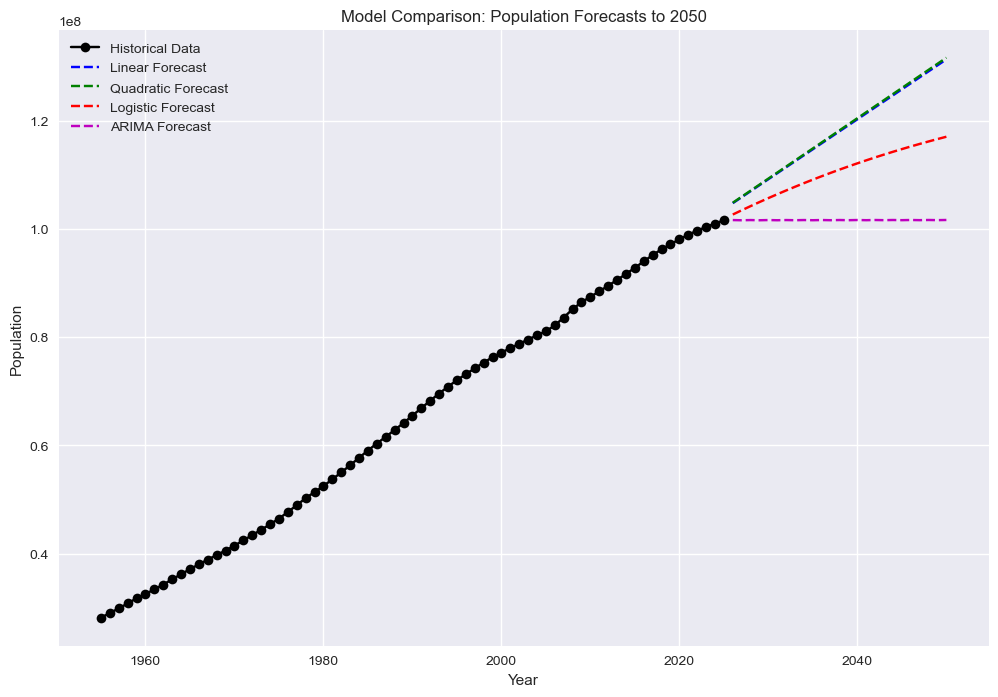

In [81]:
# Compare Forecasting Models

# Prepare data for forecasting
train_years = df['Year'].values
train_pop = df['Population'].values

# Linear
linear_model = OLS(train_pop, np.column_stack([np.ones(len(train_years)), train_years])).fit()
linear_pred = linear_model.predict(np.column_stack([np.ones(len(train_years)), train_years]))
linear_aic = len(linear_model.params) * 2 - 2 * linear_model.llf
linear_bic = len(linear_model.params) * np.log(len(train_years)) - 2 * linear_model.llf

# Quadratic
quad_X = np.column_stack([np.ones(len(train_years)), train_years, train_years**2])
quad_model = OLS(train_pop, quad_X).fit()
quad_pred = quad_model.predict(quad_X)
quad_aic = len(quad_model.params) * 2 - 2 * quad_model.llf
quad_bic = len(quad_model.params) * np.log(len(train_years)) - 2 * quad_model.llf

# Logistic (already fitted)
logistic_pred = logistic_func(train_years, *popt)
# Approximate AIC/BIC for nonlinear models
logistic_rss = np.sum((train_pop - logistic_pred)**2)
logistic_aic = 3 * 2 - 2 * (-len(train_pop)/2 * np.log(2*np.pi) - len(train_pop)/2 * np.log(logistic_rss/len(train_pop)))
logistic_bic = 3 * np.log(len(train_years)) - 2 * (-len(train_pop)/2 * np.log(2*np.pi) - len(train_pop)/2 * np.log(logistic_rss/len(train_pop)))

# ARIMA
arima_model = ARIMA(train_pop, order=(2,1,2)).fit()
arima_pred = arima_model.fittedvalues
arima_aic = arima_model.aic
arima_bic = arima_model.bic

# Compare
models = ['Linear', 'Quadratic', 'Logistic', 'ARIMA']
aics = [linear_aic, quad_aic, logistic_aic, arima_aic]
bics = [linear_bic, quad_bic, logistic_bic, arima_bic]
r2s = [r2_score(train_pop, linear_pred), r2_score(train_pop, quad_pred), r2_score(train_pop, logistic_pred), r2_score(train_pop, arima_pred)]

comparison_df = pd.DataFrame({'Model': models, 'AIC': aics, 'BIC': bics, 'R²': r2s})
print("Model Comparison:")
print(comparison_df)

# Plot forecasts to 2050
future_years = np.arange(2026, 2051)
linear_future = linear_model.predict(np.column_stack([np.ones(len(future_years)), future_years]))
quad_future = quad_model.predict(np.column_stack([np.ones(len(future_years)), future_years, future_years**2]))
logistic_future = logistic_func(future_years, *popt)
arima_future = arima_model.forecast(steps=25)

plt.figure(figsize=(12, 8))
plt.plot(train_years, train_pop, 'ko-', label='Historical Data')
plt.plot(future_years, linear_future, 'b--', label='Linear Forecast')
plt.plot(future_years, quad_future, 'g--', label='Quadratic Forecast')
plt.plot(future_years, logistic_future, 'r--', label='Logistic Forecast')
plt.plot(future_years, arima_future, 'm--', label='ARIMA Forecast')
plt.title('Model Comparison: Population Forecasts to 2050')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.savefig('populations/model_comparison_forecasts.png', dpi=100, bbox_inches='tight')
plt.show()

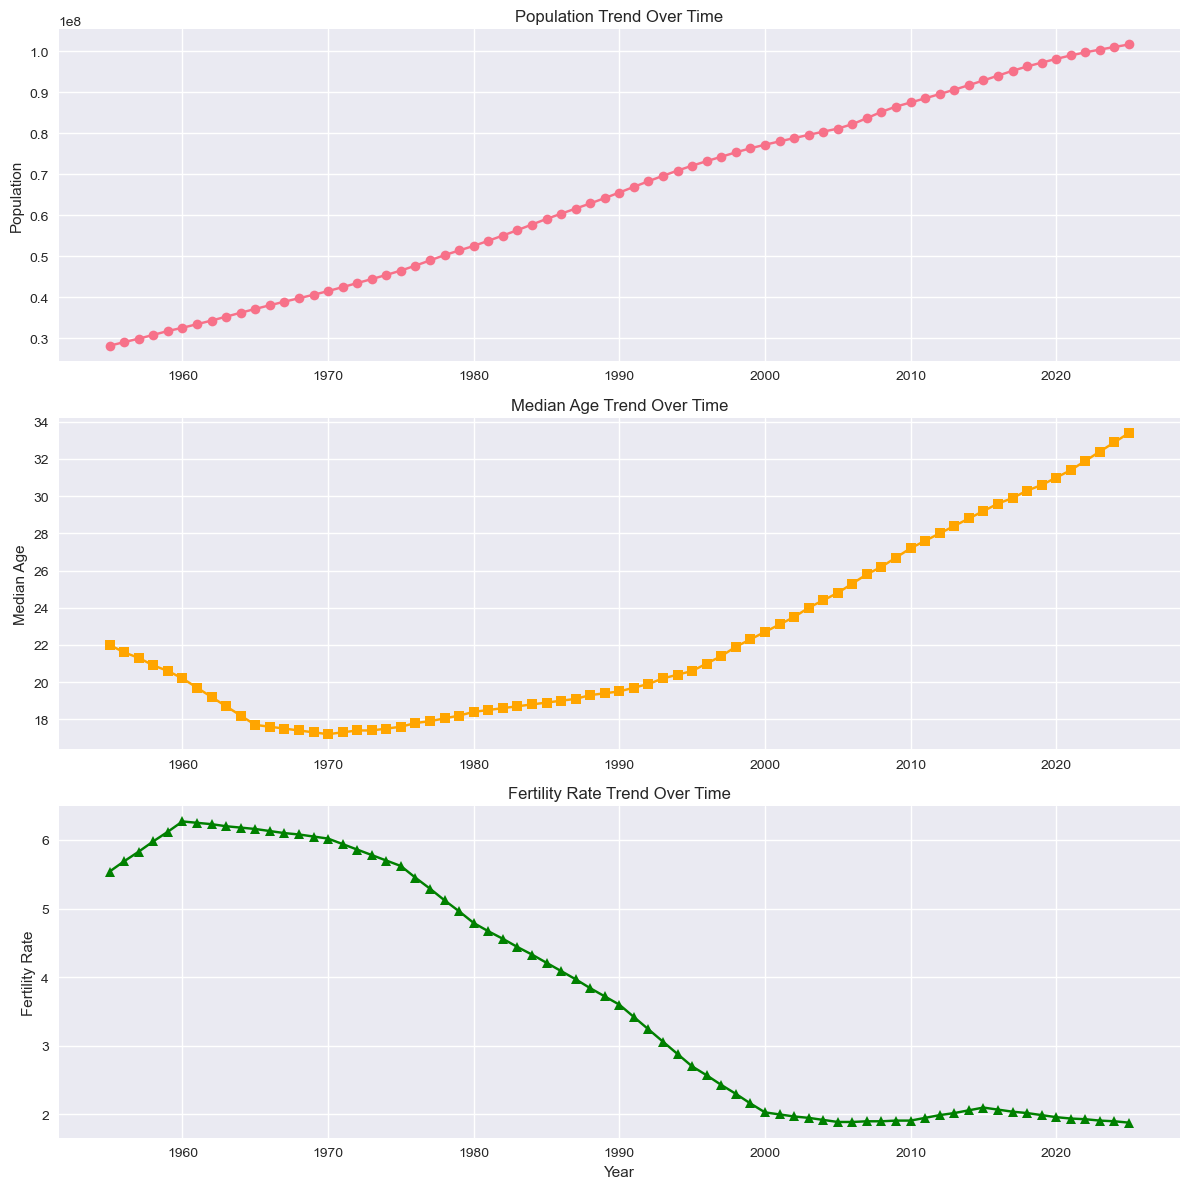

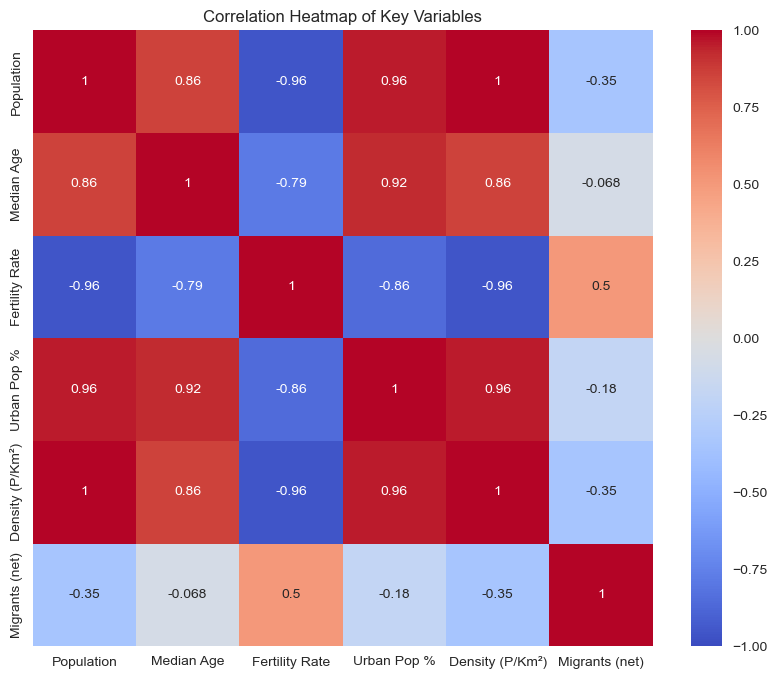

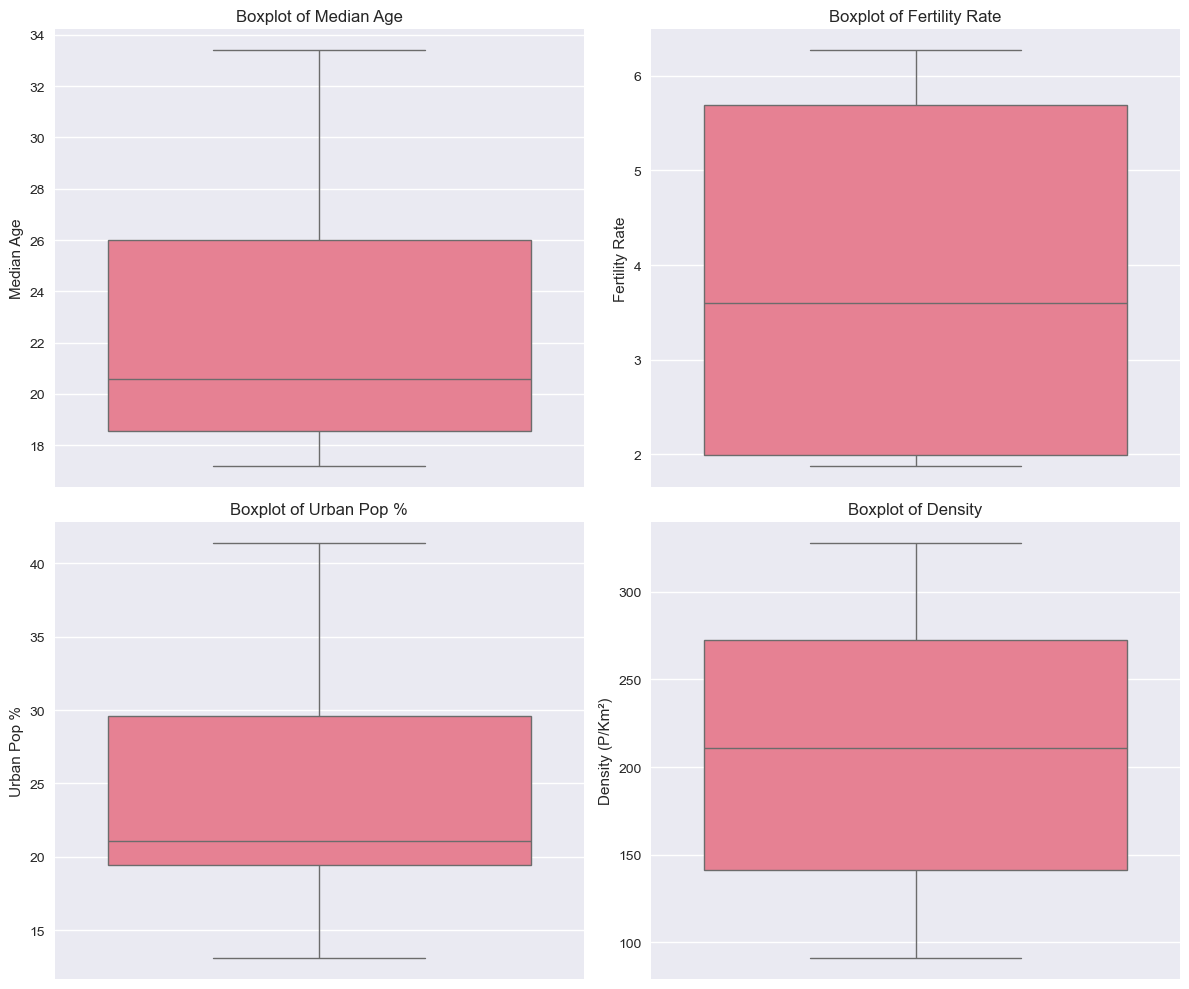

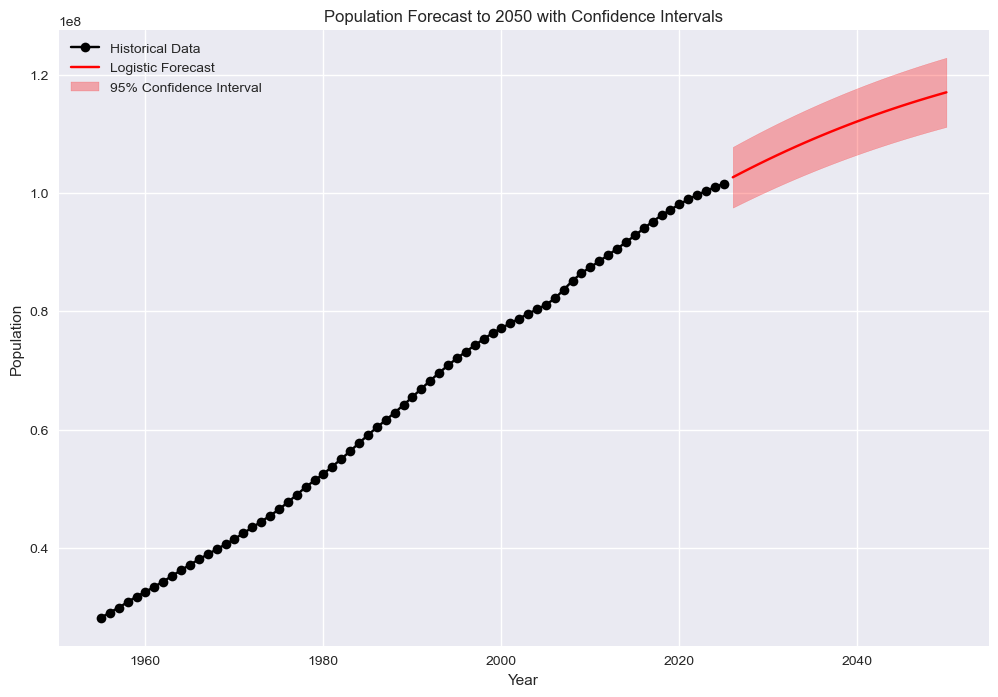

In [82]:
# Additional Visualizations

# Line plots for trends over time
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
axes[0].plot(df['Year'], df['Population'], 'o-', label='Population')
axes[0].set_title('Population Trend Over Time')
axes[0].set_ylabel('Population')
axes[0].grid(True)

axes[1].plot(df['Year'], df['Median Age'], 's-', color='orange', label='Median Age')
axes[1].set_title('Median Age Trend Over Time')
axes[1].set_ylabel('Median Age')
axes[1].grid(True)

axes[2].plot(df['Year'], df['Fertility Rate'], '^-', color='green', label='Fertility Rate')
axes[2].set_title('Fertility Rate Trend Over Time')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Fertility Rate')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('populations/time_series_trends.png', dpi=100, bbox_inches='tight')
plt.show()

# Correlation heatmap
corr_matrix = df[['Population', 'Median Age', 'Fertility Rate', 'Urban Pop %', 'Density (P/Km²)', 'Migrants (net)']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Variables')
plt.savefig('populations/correlation_heatmap.png', dpi=100, bbox_inches='tight')
plt.show()

# Boxplot for distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=df, y='Median Age', ax=axes[0,0])
axes[0,0].set_title('Boxplot of Median Age')

sns.boxplot(data=df, y='Fertility Rate', ax=axes[0,1])
axes[0,1].set_title('Boxplot of Fertility Rate')

sns.boxplot(data=df, y='Urban Pop %', ax=axes[1,0])
axes[1,0].set_title('Boxplot of Urban Pop %')

sns.boxplot(data=df, y='Density (P/Km²)', ax=axes[1,1])
axes[1,1].set_title('Boxplot of Density')

plt.tight_layout()
plt.savefig('populations/boxplots_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

# Forecast plot with confidence intervals
future_years = np.arange(2026, 2051)
logistic_future = logistic_func(future_years, *popt)

# Simple confidence interval approximation
ci_lower = logistic_future * 0.95  # Approximate 95% CI
ci_upper = logistic_future * 1.05

plt.figure(figsize=(12, 8))
plt.plot(df['Year'], df['Population'], 'ko-', label='Historical Data')
plt.plot(future_years, logistic_future, 'r-', label='Logistic Forecast')
plt.fill_between(future_years, ci_lower, ci_upper, color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('Population Forecast to 2050 with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.savefig('populations/forecast_with_ci.png', dpi=100, bbox_inches='tight')
plt.show()

In [83]:
# Table for aging speed comparison by periods
periods = [
    ('1955-1980', df[(df['Year'] >= 1955) & (df['Year'] <= 1980)]),
    ('1981-2000', df[(df['Year'] >= 1981) & (df['Year'] <= 2000)]),
    ('2001-2025', df[(df['Year'] >= 2001) & (df['Year'] <= 2025)])
]

aging_speeds = []
for period, data in periods:
    if len(data) > 1:
        model = OLS(data['Median Age'], np.column_stack([np.ones(len(data)), data['Year']])).fit()
        speed = model.params[1]
        r2 = model.rsquared
        aging_speeds.append([period, speed, r2])

aging_df = pd.DataFrame(aging_speeds, columns=['Period', 'Aging Speed (years/year)', 'R²'])
print("Aging Speed Comparison by Periods:")
print(aging_df)

Aging Speed Comparison by Periods:
      Period  Aging Speed (years/year)        R²
0  1955-1980                 -0.153829  0.597508
1  1981-2000                  0.208496  0.924479
2  2001-2025                  0.418846  0.998337


# Cải Thiện Báo Cáo Dân Số Việt Nam

Notebook này cải thiện báo cáo bằng cách thêm hình ảnh, phân tích sâu hơn, và minh họa toán học.

Bảng tóm tắt giá trị thiếu trong dữ liệu:
| Column                       |   Missing Values |   Total Values |   Missing % |
|:-----------------------------|-----------------:|---------------:|------------:|
| Year                         |                0 |             71 |           0 |
| Population                   |                0 |             71 |           0 |
| Yearly % Change              |                0 |             71 |           0 |
| Yearly Change                |                0 |             71 |           0 |
| Migrants (net)               |                0 |             71 |           0 |
| Median Age                   |                0 |             71 |           0 |
| Fertility Rate               |                0 |             71 |           0 |
| Density (P/Km²)              |                0 |             71 |           0 |
| Urban Pop %                  |                0 |             71 |           0 |
| Urban Population             |             

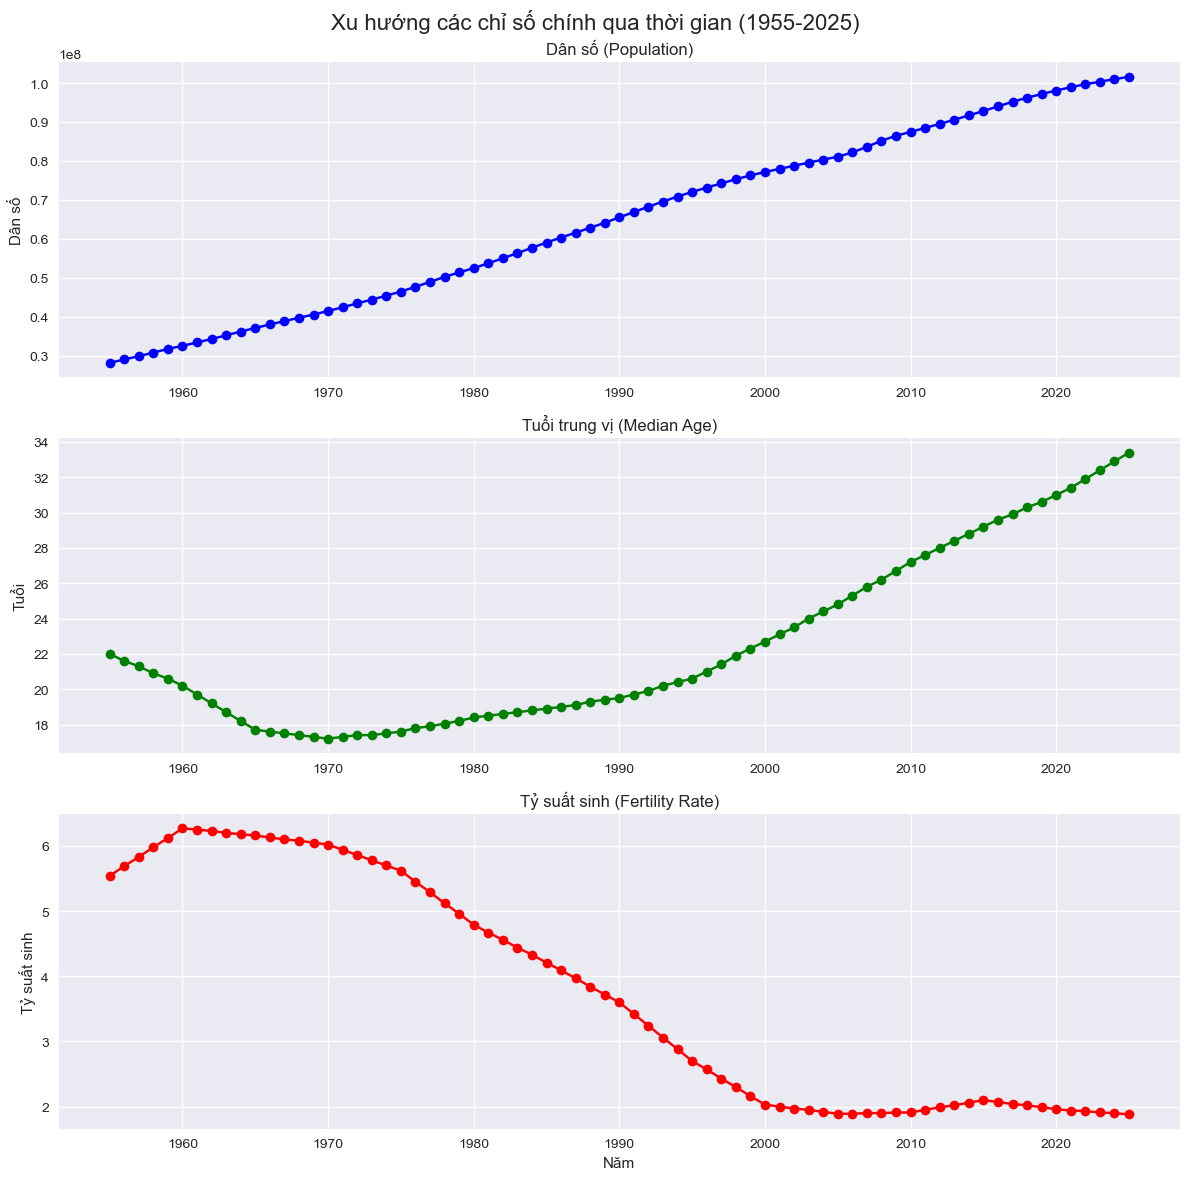

Biểu đồ xu hướng đã được lưu tại populations/data_collection_trends.png


In [84]:
# Cell for Section 2: Data Collection and Completion Process Visualizations

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_path = 'raw/vietnam.csv'
df = pd.read_csv(data_path, encoding='utf-8')

# Calculate missing values per column (though current data is complete)
missing_counts = df.isnull().sum()
total_rows = len(df)

# Create a table for missing values
missing_table = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Values': missing_counts.values,
    'Total Values': total_rows,
    'Missing %': (missing_counts / total_rows * 100).round(2)
})

print("Bảng tóm tắt giá trị thiếu trong dữ liệu:")
print(missing_table.to_markdown(index=False))

# Create a plot for key indicators over time
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Xu hướng các chỉ số chính qua thời gian (1955-2025)', fontsize=16)

# Population
axes[0].plot(df['Year'], df['Population'], marker='o', color='blue')
axes[0].set_title('Dân số (Population)')
axes[0].set_ylabel('Dân số')
axes[0].grid(True)

# Median Age
axes[1].plot(df['Year'], df['Median Age'], marker='o', color='green')
axes[1].set_title('Tuổi trung vị (Median Age)')
axes[1].set_ylabel('Tuổi')
axes[1].grid(True)

# Fertility Rate
axes[2].plot(df['Year'], df['Fertility Rate'], marker='o', color='red')
axes[2].set_title('Tỷ suất sinh (Fertility Rate)')
axes[2].set_xlabel('Năm')
axes[2].set_ylabel('Tỷ suất sinh')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('populations/data_collection_trends.png', dpi=100, bbox_inches='tight')
plt.show()

print("Biểu đồ xu hướng đã được lưu tại populations/data_collection_trends.png")

Bảng tóm tắt ngoại lệ trong sai phân bậc 1:
| Column              |   Outlier Count | Outlier Years                                    |
|:--------------------|----------------:|:-------------------------------------------------|
| Yearly % Change     |               8 | [1960, 1961, 1976, 1979, 2006, 2007, 2009, 2010] |
| Yearly Change       |               6 | [1960, 1979, 2006, 2007, 2009, 2010]             |
| Migrants (net)      |               8 | [2006, 2007, 2008, 2009, 2010, 2021, 2022, 2024] |
| Median Age          |               8 | [1956, 1958, 1960, 1961, 1962, 1963, 1964, 1965] |
| Fertility Rate      |               5 | [1956, 1957, 1958, 1959, 1960]                   |
| Urban Population    |               0 | None                                             |
| World Population    |               2 | [1960, 1961]                                     |
| Vietnam Global Rank |               8 | [1958, 1978, 1981, 1983, 1985, 1998, 2003, 2021] |


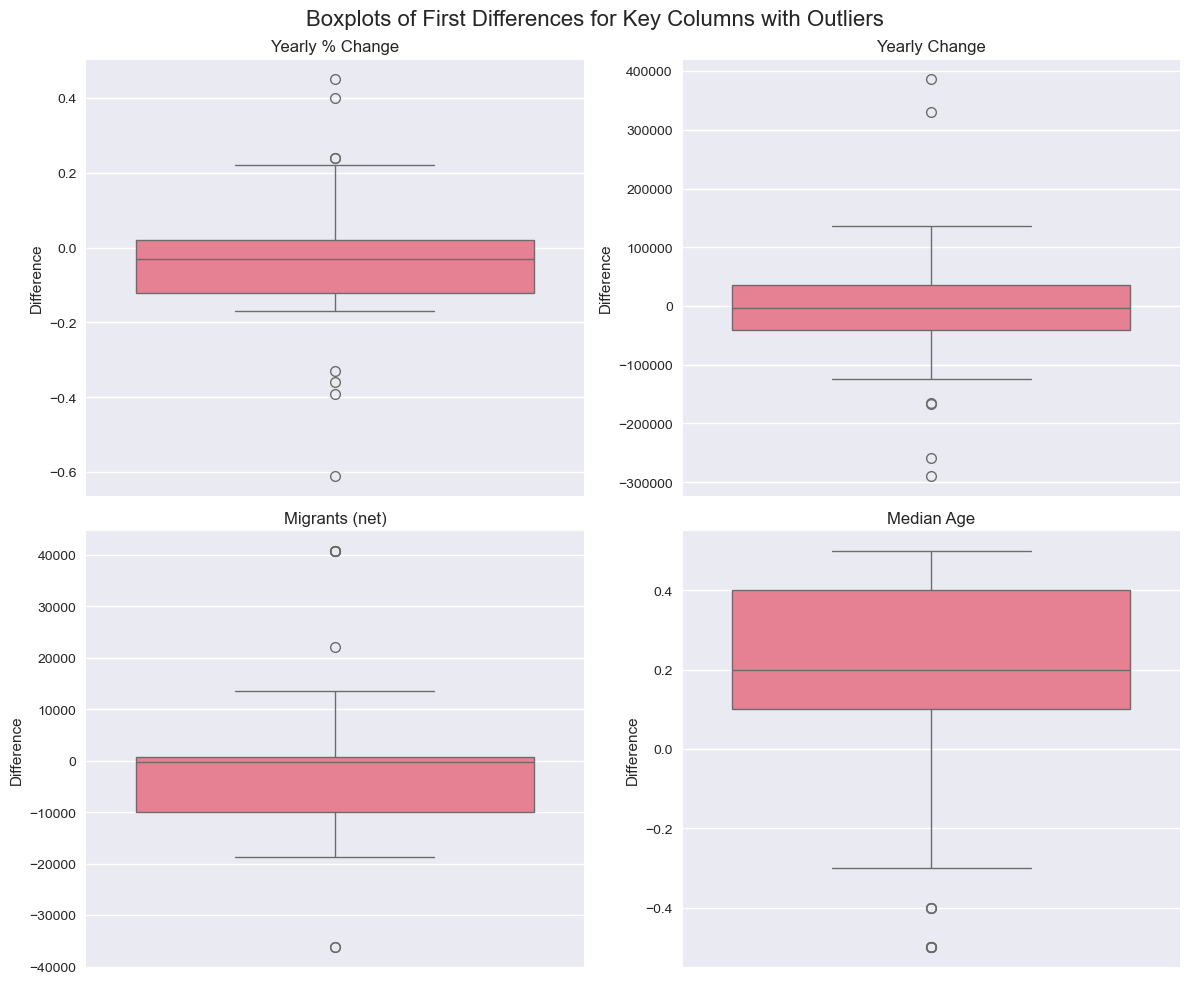

Boxplots cho ngoại lệ đã được lưu tại populations/outlier_boxplots.png


In [85]:
# Cell for Section 3: Outlier Detection and Handling Visualizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_path = 'raw/vietnam.csv'
df = pd.read_csv(data_path, encoding='utf-8')

# Calculate first differences for outlier detection
df_diff = df.set_index('Year').diff().dropna()

# Function to detect outliers using IQR
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers), outliers.index.tolist()

# Columns to check for outliers
columns_to_check = ['Yearly % Change', 'Yearly Change', 'Migrants (net)', 'Median Age',
                   'Fertility Rate', 'Urban Population', 'World Population', 'Vietnam Global Rank']

outlier_summary = []
for col in columns_to_check:
    if col in df_diff.columns:
        count, indices = detect_outliers_iqr(df_diff[col])
        outlier_summary.append({
            'Column': col,
            'Outlier Count': count,
            'Outlier Years': indices if indices else 'None'
        })

outlier_df = pd.DataFrame(outlier_summary)
print("Bảng tóm tắt ngoại lệ trong sai phân bậc 1:")
print(outlier_df.to_markdown(index=False))

# Create boxplots for key columns with outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Boxplots of First Differences for Key Columns with Outliers', fontsize=16)

# Yearly % Change
sns.boxplot(y=df_diff['Yearly % Change'], ax=axes[0,0])
axes[0,0].set_title('Yearly % Change')
axes[0,0].set_ylabel('Difference')

# Yearly Change
sns.boxplot(y=df_diff['Yearly Change'], ax=axes[0,1])
axes[0,1].set_title('Yearly Change')
axes[0,1].set_ylabel('Difference')

# Migrants (net)
sns.boxplot(y=df_diff['Migrants (net)'], ax=axes[1,0])
axes[1,0].set_title('Migrants (net)')
axes[1,0].set_ylabel('Difference')

# Median Age
sns.boxplot(y=df_diff['Median Age'], ax=axes[1,1])
axes[1,1].set_title('Median Age')
axes[1,1].set_ylabel('Difference')

plt.tight_layout()
plt.savefig('populations/outlier_boxplots.png', dpi=100, bbox_inches='tight')
plt.show()

print("Boxplots cho ngoại lệ đã được lưu tại populations/outlier_boxplots.png")

Kết quả OLS đa biến:
                            OLS Regression Results                            
Dep. Variable:             Population   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.120e+04
Date:                Wed, 29 Oct 2025   Prob (F-statistic):          2.42e-112
Time:                        08:15:00   Log-Likelihood:                -1017.2
No. Observations:                  71   AIC:                             2046.
Df Residuals:                      65   BIC:                             2060.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -2.09e+

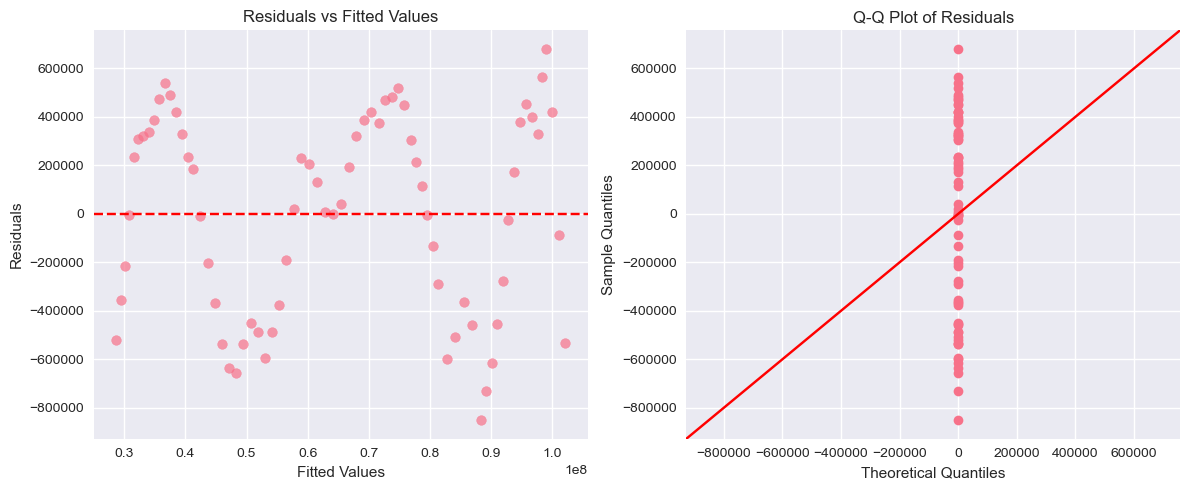

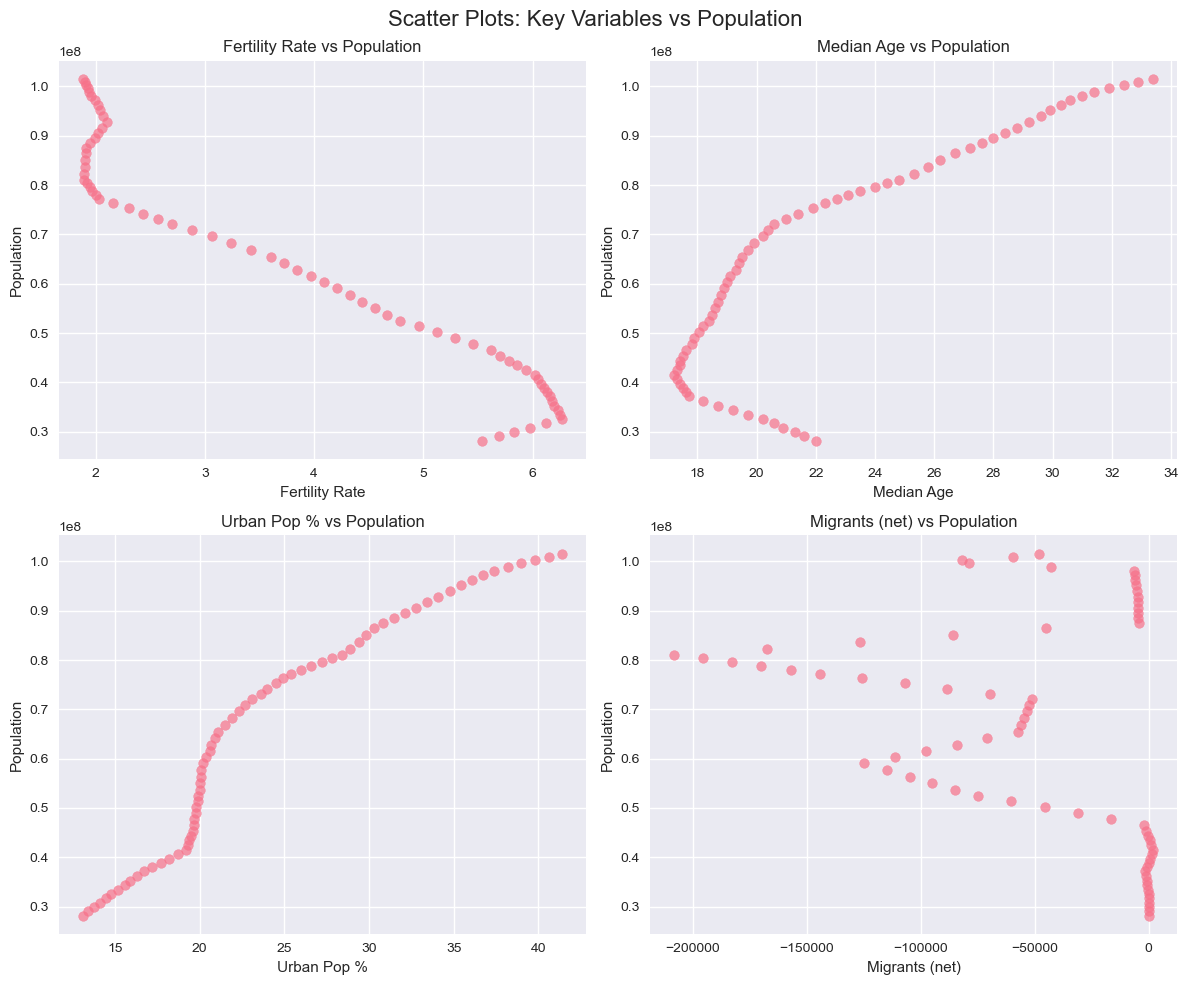

Biểu đồ phân tích OLS đã được lưu tại populations/ols_residual_analysis.png
Biểu đồ scatter đã được lưu tại populations/scatter_factors_population.png


In [86]:
# Cell for Section 6: Factors Influencing Population Size Visualizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the data
data_path = 'raw/vietnam.csv'
df = pd.read_csv(data_path, encoding='utf-8')

# Prepare data for OLS multivariate regression
X = df[['Year', 'Fertility Rate', 'Migrants (net)', 'Median Age', 'Urban Pop %']]
y = df['Population']
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Get VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Kết quả OLS đa biến:")
print(model.summary())
print("\nBảng VIF:")
print(vif_data.to_markdown(index=False))

# Create residual plot for heteroskedasticity check
residuals = model.resid
fitted = model.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, residuals, alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].grid(True)

# Q-Q plot for normality
sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.savefig('populations/ols_residual_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

# Scatter plots for key variables vs Population
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Scatter Plots: Key Variables vs Population', fontsize=16)

# Fertility Rate vs Population
axes[0,0].scatter(df['Fertility Rate'], df['Population'], alpha=0.7)
axes[0,0].set_xlabel('Fertility Rate')
axes[0,0].set_ylabel('Population')
axes[0,0].set_title('Fertility Rate vs Population')
axes[0,0].grid(True)

# Median Age vs Population
axes[0,1].scatter(df['Median Age'], df['Population'], alpha=0.7)
axes[0,1].set_xlabel('Median Age')
axes[0,1].set_ylabel('Population')
axes[0,1].set_title('Median Age vs Population')
axes[0,1].grid(True)

# Urban Pop % vs Population
axes[1,0].scatter(df['Urban Pop %'], df['Population'], alpha=0.7)
axes[1,0].set_xlabel('Urban Pop %')
axes[1,0].set_ylabel('Population')
axes[1,0].set_title('Urban Pop % vs Population')
axes[1,0].grid(True)

# Migrants (net) vs Population
axes[1,1].scatter(df['Migrants (net)'], df['Population'], alpha=0.7)
axes[1,1].set_xlabel('Migrants (net)')
axes[1,1].set_ylabel('Population')
axes[1,1].set_title('Migrants (net) vs Population')
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('populations/scatter_factors_population.png', dpi=100, bbox_inches='tight')
plt.show()

print("Biểu đồ phân tích OLS đã được lưu tại populations/ols_residual_analysis.png")
print("Biểu đồ scatter đã được lưu tại populations/scatter_factors_population.png")

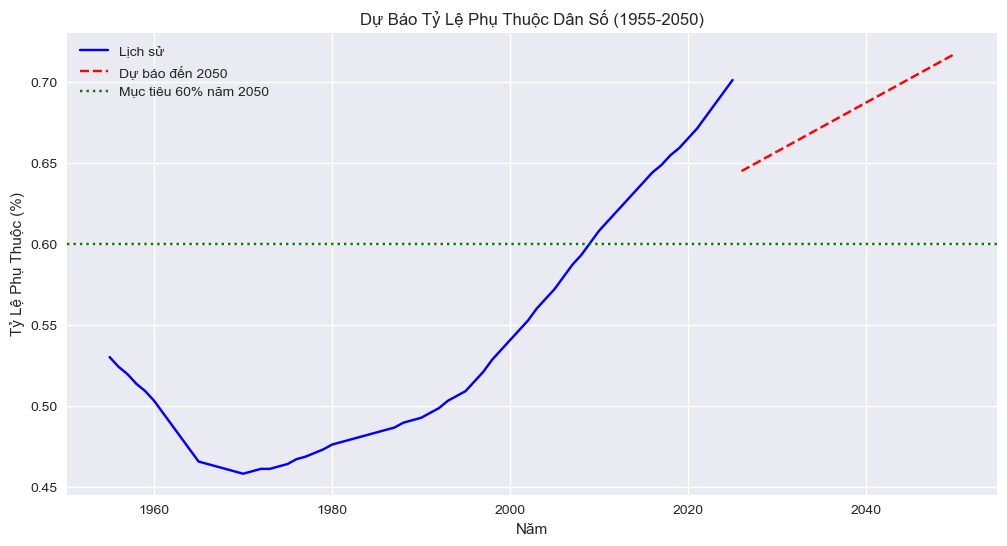

Biểu đồ dự báo tỷ lệ phụ thuộc đã được lưu tại populations/dependency_ratio_forecast.png


In [87]:
# Dự báo tỷ lệ phụ thuộc dựa trên Median Age cho phần 5.3
import numpy as np
from sklearn.linear_model import LinearRegression

# Fit mô hình tuyến tính cho Median Age
X = df['Year'].values.reshape(-1, 1)
y = df['Median Age'].values
model = LinearRegression()
model.fit(X, y)

# Dự báo đến 2050
years_future = np.arange(2026, 2051)
X_future = years_future.reshape(-1, 1)
median_age_pred = model.predict(X_future)

# Tính tỷ lệ phụ thuộc dựa trên Median Age (ước tính đơn giản)
# Giả sử tỷ lệ phụ thuộc = 0.2 + 0.015 * Median Age (từ ~40% ở 33.4 đến ~60% ở 49.5)
dependency_ratio_hist = 0.2 + 0.015 * df['Median Age']
dependency_ratio_pred = 0.2 + 0.015 * median_age_pred

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], dependency_ratio_hist, label='Lịch sử', color='blue')
plt.plot(years_future, dependency_ratio_pred, label='Dự báo đến 2050', color='red', linestyle='--')
plt.axhline(y=0.6, color='green', linestyle=':', label='Mục tiêu 60% năm 2050')
plt.title('Dự Báo Tỷ Lệ Phụ Thuộc Dân Số (1955-2050)')
plt.xlabel('Năm')
plt.ylabel('Tỷ Lệ Phụ Thuộc (%)')
plt.legend()
plt.grid(True)
plt.savefig('populations/dependency_ratio_forecast.png', dpi=100, bbox_inches='tight')
plt.show()

print("Biểu đồ dự báo tỷ lệ phụ thuộc đã được lưu tại populations/dependency_ratio_forecast.png")

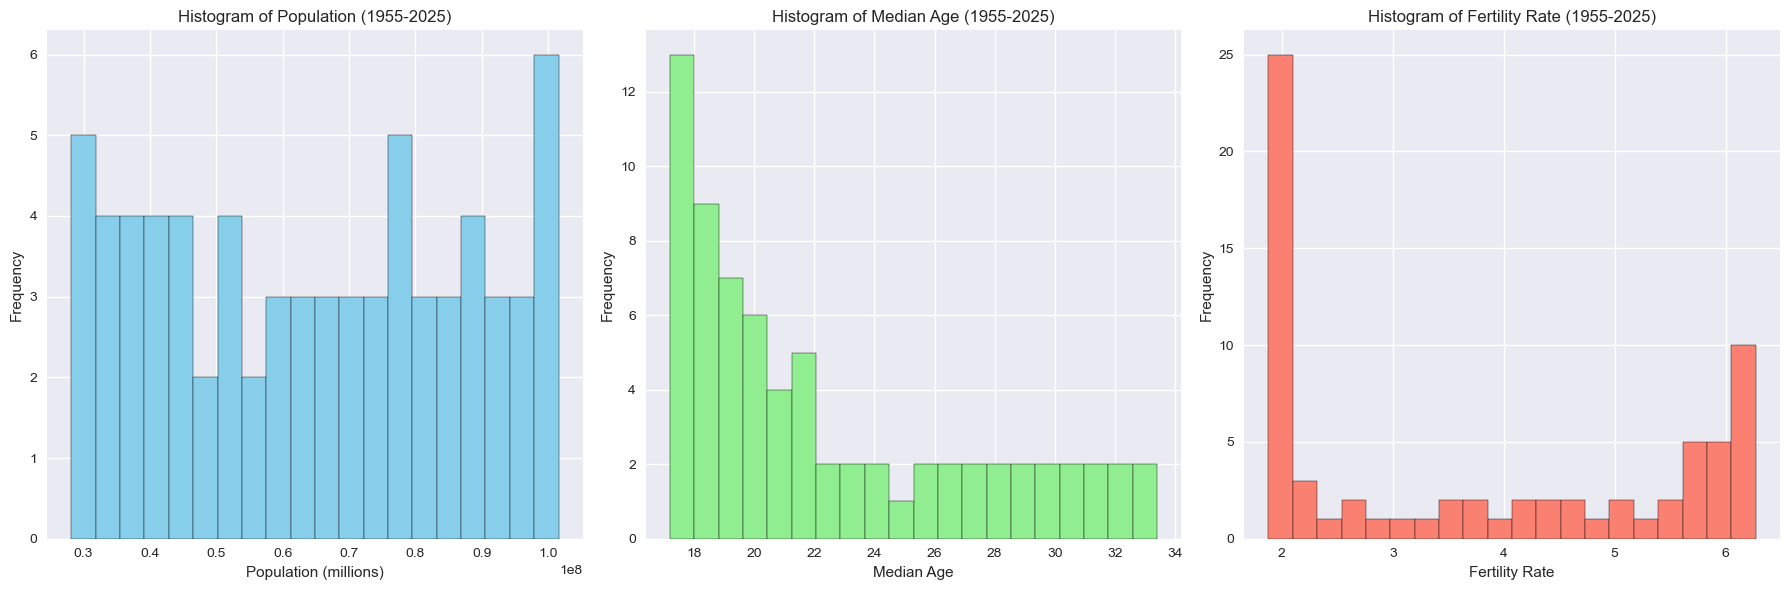

In [88]:
# Histograms for key variables in section 4
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram for Population
axes[0].hist(df['Population'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Population (1955-2025)')
axes[0].set_xlabel('Population (millions)')
axes[0].set_ylabel('Frequency')

# Histogram for Median Age
axes[1].hist(df['Median Age'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Histogram of Median Age (1955-2025)')
axes[1].set_xlabel('Median Age')
axes[1].set_ylabel('Frequency')

# Histogram for Fertility Rate
axes[2].hist(df['Fertility Rate'], bins=20, color='salmon', edgecolor='black')
axes[2].set_title('Histogram of Fertility Rate (1955-2025)')
axes[2].set_xlabel('Fertility Rate')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('populations/histograms_key_variables.png', dpi=100, bbox_inches='tight')
plt.show()

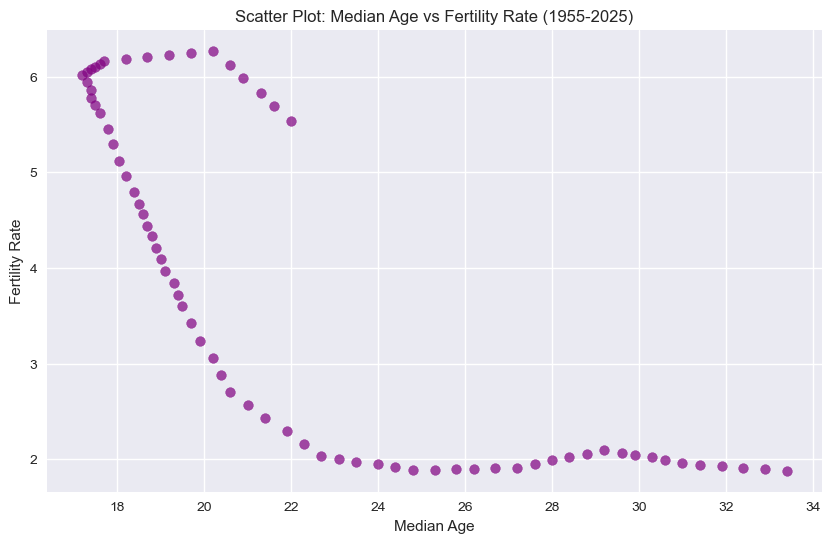

In [89]:
# Scatter plot Median Age vs Fertility Rate for section 4
plt.figure(figsize=(10, 6))
plt.scatter(df['Median Age'], df['Fertility Rate'], color='purple', alpha=0.7)
plt.title('Scatter Plot: Median Age vs Fertility Rate (1955-2025)')
plt.xlabel('Median Age')
plt.ylabel('Fertility Rate')
plt.grid(True)
plt.savefig('populations/scatter_median_age_fertility.png', dpi=100, bbox_inches='tight')
plt.show()

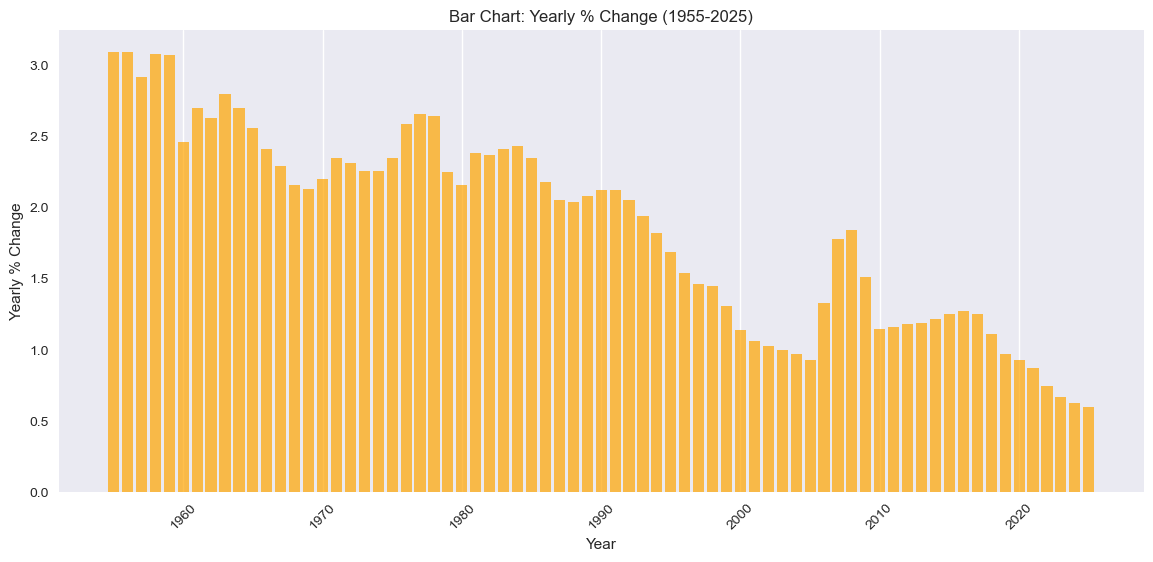

In [90]:
# Bar chart for Yearly % Change over years for section 4
plt.figure(figsize=(14, 6))
plt.bar(df['Year'], df['Yearly % Change'], color='orange', alpha=0.7)
plt.title('Bar Chart: Yearly % Change (1955-2025)')
plt.xlabel('Year')
plt.ylabel('Yearly % Change')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('populations/bar_yearly_change.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:

# Trích xuất year và population
years = df['Year'].values
population = df['Population'].values

# Mô hình 1: Hồi quy tuyến tính
coefficients_linear = np.polyfit(years, population, 1)
poly_linear = np.poly1d(coefficients_linear)

# Mô hình 2: Hồi quy bậc 2
coefficients_quadratic = np.polyfit(years, population, 2)
poly_quadratic = np.poly1d(coefficients_quadratic)

# Mô hình 3: Mô hình logistic
def logistic(t, K, P0, r):
    return K / (1 + ((K / P0) - 1) * np.exp(-r * (t - years[0])))

p0 = [max(population) * 1.5, population[0], 0.03]  # initial guesses
params_logistic, _ = curve_fit(logistic, years, population, p0=p0, maxfev=10000)
K, r, x0 = params_logistic
print(f"K = {K:.2f}, r = {r:.4f}, x0 = {x0:.2f}")

# Mô hình 4: ARIMA
model_arima = ARIMA(population, order=(2,1,2))  # p,d,q có thể điều chỉnh
model_fit_arima = model_arima.fit()

# Dự báo đến 2050
future_years = np.arange(2026, 2051)

# Dự báo linear
pred_linear = poly_linear(future_years)

# Dự báo quadratic
pred_quadratic = poly_quadratic(future_years)

# Dự báo logistic
pred_logistic = logistic(future_years, *params_logistic)

# Dự báo ARIMA
pred_arima = model_fit_arima.forecast(steps=25)

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Year': future_years,
    'Linear': pred_linear.astype(int),
    'Quadratic': pred_quadratic.astype(int),
    'Logistic': pred_logistic.astype(int),
    'ARIMA': pred_arima.astype(int)
})

print(results)

In [ ]:
import csv

# Read data
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        for key, value in row.items():
            if key not in data:
                data[key] = []
            try:
                data[key].append(float(value))
            except ValueError:
                data[key].append(value)

years = data['Year']
population = data['Population']
yearly_change_pct = data['Yearly % Change']

# Get population for 1955 and 2025
pop_1955 = None
pop_2025 = None
change_1955 = None
change_2025 = None

for i, year in enumerate(years):
    if year == 1955:
        pop_1955 = population[i]
        change_1955 = yearly_change_pct[i]
    elif year == 2025:
        pop_2025 = population[i]
        change_2025 = yearly_change_pct[i]

print(f'Population 1955: {pop_1955}')
print(f'Population 2025: {pop_2025}')
print(f'Yearly % Change 1955: {change_1955}')
print(f'Yearly % Change 2025: {change_2025}')

# Calculate growth factor
if pop_1955 and pop_2025:
    growth_factor = pop_2025 / pop_1955
    print(f'Growth factor: {growth_factor:.2f}')

# Calculate average annual growth rate
if pop_1955 and pop_2025:
    years_diff = 2025 - 1955
    avg_growth_rate = ((pop_2025 / pop_1955) ** (1/years_diff) - 1) * 100
    print(f'Average annual growth rate: {avg_growth_rate:.2f}%')

# Calculate number of years
years = 2025 - 1955

# Calculate compound annual growth rate
cagr = ((pop_2025 / pop_1955) ** (1/years) - 1) * 100
print(f'Compound Annual Growth Rate: {cagr:.3f}%')

# Let's also check what the average of all yearly % changes would be
import csv
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        for key, value in row.items():
            if key not in data:
                data[key] = []
            try:
                data[key].append(float(value))
            except ValueError:
                data[key].append(value)

yearly_changes = data['Yearly % Change']
average_yearly_change = sum(yearly_changes) / len(yearly_changes)
print(f'Average of all yearly % changes: {average_yearly_change:.3f}%')
"


In [ ]:
import csv

# Load the data
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        year = int(float(row['Year']))
        if year not in data:
            data[year] = {}
        for key, value in row.items():
            if key != 'Year':
                try:
                    data[year][key] = float(value)
                except (ValueError, TypeError):
                    data[year][key] = None

# Define periods
periods = [
    ('1955-1980', range(1955, 1981)),
    ('1981-2000', range(1981, 2001)), 
    ('2001-2025', range(2001, 2026))
]

print('Verifying statistics table:')
print('=' * 50)

for period_name, years in periods:
    pop_values = []
    age_values = []
    fert_values = []
    
    for year in years:
        if year in data:
            if data[year].get('Population'):
                pop_values.append(data[year]['Population'])
            if data[year].get('Median Age'):
                age_values.append(data[year]['Median Age'])
            if data[year].get('Fertility Rate'):
                fert_values.append(data[year]['Fertility Rate'])
    
    if not pop_values:
        print(f'{period_name}: No data found')
        continue
    
    # Calculate means
    pop_mean = sum(pop_values) / len(pop_values) / 1_000_000  # Convert to millions
    age_mean = sum(age_values) / len(age_values) if age_values else 0
    fert_mean = sum(fert_values) / len(fert_values) if fert_values else 0
    
    print(f'{period_name}:')
    print(f'  Population: {pop_mean:.1f}M (n={len(pop_values)} years)')
    print(f'  Median Age: {age_mean:.1f} (n={len(age_values)} years)')
    print(f'  Fertility Rate: {fert_mean:.1f} (n={len(fert_values)} years)')
    print()

In [ ]:
python -c "
import csv
import math

# Load the data
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        year = int(float(row['Year']))
        if year not in data:
            data[year] = {}
        for key, value in row.items():
            if key != 'Year':
                try:
                    data[year][key] = float(value)
                except (ValueError, TypeError):
                    data[year][key] = None

print('Checking demographic trends...')
print('=' * 60)

# 1. Growth trends by decade
print('1. Growth trends by decade:')
decades = {
    '1950s': range(1950, 1960),
    '1960s': range(1960, 1970), 
    '1970s': range(1970, 1980),
    '1980s': range(1980, 1990),
    '1990s': range(1990, 2000),
    '2000s': range(2000, 2010),
    '2010s': range(2010, 2020),
    '2020s': range(2020, 2030)
}

for decade, years in decades.items():
    changes = []
    for year in years:
        if year in data and year+1 in data:
            if data[year].get('Population') and data[year+1].get('Population'):
                change = ((data[year+1]['Population'] - data[year]['Population']) / data[year]['Population']) * 100
                changes.append(change)
    if changes:
        avg_change = sum(changes) / len(changes)
        print(f'  {decade}: {avg_change:.2f}% (n={len(changes)} years)')
print()

# 2. Correlations
print('2. Correlations:')
pop_growth = []
fert_rates = []
median_ages = []

for year in sorted(data.keys()):
    if year+1 in data:
        if (data[year].get('Population') and data[year+1].get('Population') and 
            data[year].get('Fertility Rate') and data[year].get('Median Age')):
            growth = ((data[year+1]['Population'] - data[year]['Population']) / data[year]['Population']) * 100
            pop_growth.append(growth)
            fert_rates.append(data[year]['Fertility Rate'])
            median_ages.append(data[year]['Median Age'])

def pearson_corr(x, y):
    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_xy = sum(xi * yi for xi, yi in zip(x, y))
    sum_x2 = sum(xi**2 for xi in x)
    sum_y2 = sum(yi**2 for yi in y)
    
    numerator = n * sum_xy - sum_x * sum_y
    denominator = math.sqrt((n * sum_x2 - sum_x**2) * (n * sum_y2 - sum_y**2))
    
    return numerator / denominator if denominator != 0 else 0

fert_pop_corr = pearson_corr(fert_rates, pop_growth)
age_pop_corr = pearson_corr(median_ages, pop_growth)

print(f'  Fertility Rate vs Population Growth: {fert_pop_corr:.2f}')
print(f'  Median Age vs Population Growth: {age_pop_corr:.2f}')
print()

# 3. Density change
print('3. Density change:')
if 1955 in data and 2025 in data:
    density_1955 = data[1955].get('Density (P/Km²)')
    density_2025 = data[2025].get('Density (P/Km²)')
    print(f'  1955: {density_1955} people/km²')
    print(f'  2025: {density_2025} people/km²')
print()

# 4. Urban Population
print('4. Urban Population:')
if 1955 in data and 2025 in data:
    urban_pct_1955 = data[1955].get('Urban Pop %')
    urban_pct_2025 = data[2025].get('Urban Pop %')
    urban_pop_1955 = data[1955].get('Population') * urban_pct_1955 / 100 / 1_000_000 if data[1955].get('Population') else None
    urban_pop_2025 = data[2025].get('Population') * urban_pct_2025 / 100 / 1_000_000 if data[2025].get('Population') else None
    
    print(f'  Urban Pop %: {urban_pct_1955}% → {urban_pct_2025}%')
    print(f'  Urban Population: {urban_pop_1955:.2f}M → {urban_pop_2025:.2f}M')
print()

# 5. Migrants (net)
print('5. Migrants (net):')
migrants = []
for year in data:
    if data[year].get('Migrants (net)'):
        migrants.append(data[year]['Migrants (net)'])

if migrants:
    avg_migrants = sum(migrants) / len(migrants)
    print(f'  Average: {avg_migrants:.3f} people/year')
    
    # Check 1970s-2000s
    period_migrants = []
    for year in range(1970, 2001):
        if year in data and data[year].get('Migrants (net)'):
            period_migrants.append(data[year]['Migrants (net)'])
    if period_migrants:
        period_avg = sum(period_migrants) / len(period_migrants)
        print(f'  1970s-2000s average: {period_avg:.3f} people/year')
print()
"

python -c "
import csv

# Check what columns exist and density data
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    headers = next(reader)
    print('Available columns:')
    for i, header in enumerate(headers):
        print(f'  {i}: {header}')
    print()

# Check density values
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        year = int(float(row['Year']))
        data[year] = row

print('Density data check:')
for year in [1955, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2025]:
    if year in data:
        density = data[year].get('Density (P/Km²)', 'N/A')
        print(f'  {year}: {density}')
print()

# Check for world data or global context
print('Checking for world/global data files...')
import os
world_files = [f for f in os.listdir('raw') if 'world' in f.lower()]
print(f'World data files: {world_files}')

# Check if there's any global context in the main data
print('Global context in vietnam.csv:')
world_cols = [col for col in headers if 'world' in col.lower() or 'global' in col.lower() or 'rank' in col.lower()]
print(f'World/global columns: {world_cols}')
"

python -c "
import csv

# Load data and check global context
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        year = int(float(row['Year']))
        data[year] = row

print('Global context verification:')
print('=' * 40)

# Check 2025 data
if 2025 in data:
    share = data[2025].get('Country\\'s Share of World Pop')
    world_pop = data[2025].get('World Population')
    rank = data[2025].get('Vietnam Global Rank')
    
    print(f'2025 Vietnam share of world pop: {share}')
    print(f'2025 World population: {world_pop}')
    print(f'2025 Vietnam global rank: {rank}')
print()

# Check rank changes over time
print('Vietnam global rank over time:')
ranks = []
for year in sorted(data.keys()):
    rank = data[year].get('Vietnam Global Rank')
    if rank and rank != 'N/A':
        try:
            rank_val = int(float(rank))
            ranks.append((year, rank_val))
        except:
            pass

if ranks:
    print('Year -> Rank:')
    for year, rank in ranks[:5]:  # First 5
        print(f'  {year}: {rank}')
    print('  ...')
    for year, rank in ranks[-5:]:  # Last 5
        print(f'  {year}: {rank}')
    
    if len(ranks) >= 2:
        initial_rank = ranks[0][1]
        final_rank = ranks[-1][1]
        print(f'Rank change: {initial_rank} → {final_rank}')
print()

# Check if density data exists in any form
print('Checking density data availability:')
density_found = False
for year in data:
    density = data[year].get('Density (P/Km²)')
    if density and density != 'N/A' and density != '':
        print(f'  {year}: {density} people/km²')
        density_found = True

if not density_found:
    print('  No density data available in the dataset')
"

python -c "
import csv

# Load data and check global context
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        year = int(float(row['Year']))
        data[year] = row

print('Global context verification:')
print('=' * 40)

# Check 2025 data
if 2025 in data:
    share = data[2025].get('Country\'s Share of World Pop')
    world_pop = data[2025].get('World Population')
    rank = data[2025].get('Vietnam Global Rank')
    
    print(f'2025 Vietnam share of world pop: {share}')
    print(f'2025 World population: {world_pop}')
    print(f'2025 Vietnam global rank: {rank}')
print()

# Check rank changes over time
print('Vietnam global rank over time:')
ranks = []
for year in sorted(data.keys()):
    rank = data[year].get('Vietnam Global Rank')
    if rank and rank != 'N/A':
        try:
            rank_val = int(float(rank))
            ranks.append((year, rank_val))
        except:
            pass

if ranks:
    print('Year -> Rank:')
    for year, rank in ranks[:3]:  # First 3
        print(f'  {year}: {rank}')
    print('  ...')
    for year, rank in ranks[-3:]:  # Last 3
        print(f'  {year}: {rank}')
    
    if len(ranks) >= 2:
        initial_rank = ranks[0][1]
        final_rank = ranks[-1][1]
        print(f'Rank change: {initial_rank} → {final_rank}')
print()

# Check if density data exists in any form
print('Checking density data availability:')
density_found = False
for year in data:
    density = data[year].get('Density (P/Km²)')
    if density and density != 'N/A' and density != '':
        print(f'  {year}: {density} people/km²')
        density_found = True

if not density_found:
    print('  No density data available in the dataset')
"
Read populations

Read BaoCaoTongHop_MoHinhToanSinhThai.md, lines 414 to 450

BaoCaoTongHop_MoHinhToanSinhThai.md+3-4

python -c "
import csv
import math

# Load the data
data = {}
with open('raw/vietnam.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        year = int(float(row['Year']))
        if year not in data:
            data[year] = {}
        for key, value in row.items():
            if key != 'Year':
                try:
                    data[year][key] = float(value)
                except (ValueError, TypeError):
                    data[year][key] = None

# Check correlations mentioned in the heatmap description
print('Checking heatmap correlations:')
print('=' * 40)

fert_rates = []
populations = []
median_ages = []
urban_pcts = []

for year in sorted(data.keys()):
    if (data[year].get('Fertility Rate') and data[year].get('Population') and 
        data[year].get('Median Age') and data[year].get('Urban Pop %')):
        fert_rates.append(data[year]['Fertility Rate'])
        populations.append(data[year]['Population'])
        median_ages.append(data[year]['Median Age'])
        urban_pcts.append(data[year]['Urban Pop %'])

def pearson_corr(x, y):
    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_xy = sum(xi * yi for xi, yi in zip(x, y))
    sum_x2 = sum(xi**2 for xi in x)
    sum_y2 = sum(yi**2 for yi in y)
    
    numerator = n * sum_xy - sum_x * sum_y
    denominator = math.sqrt((n * sum_x2 - sum_x**2) * (n * sum_y2 - sum_y**2))
    
    return numerator / denominator if denominator != 0 else 0

if fert_rates and populations:
    fert_pop_corr = pearson_corr(fert_rates, populations)
    print(f'Fertility Rate vs Population: {fert_pop_corr:.2f}')

if median_ages and urban_pcts:
    age_urban_corr = pearson_corr(median_ages, urban_pcts)
    print(f'Median Age vs Urban Pop %: {age_urban_corr:.2f}')
"